# Example TractableBufferStockModel

In [1]:
# An alternative, much longer way to solve the TBS model
from time import process_time  # timing utility

import numpy as np  # numeric Python

from HARK.ConsumptionSaving.ConsMarkovModel import (
    MarkovConsumerType,
)
from HARK.ConsumptionSaving.TractableBufferStockModel import TractableConsumerType
from HARK.distributions import DiscreteDistributionLabeled
from HARK.utilities import plot_funcs  # basic plotting tools

do_simulation = True

In [2]:
# Define the model primitives
base_primitives = {
    "UnempPrb": 0.00625,  # Probability of becoming unemployed
    "DiscFac": 0.975,  # Intertemporal discount factor
    "Rfree": 1.01,  # Risk-free interest factor on assets
    "PermGroFac": 1.0025,  # Permanent income growth factor (uncompensated)
    "CRRA": 1.0,
}  # Coefficient of relative risk aversion

In [3]:
# Define a dictionary to be used in case of simulation
simulation_values = {
    "aLvlInitMean": 0.0,  # Mean of log initial assets for new agents
    "aLvlInitStd": 1.0,  # Stdev of log initial assets for new agents
    "AgentCount": 10000,  # Number of agents to simulate
    "T_sim": 120,  # Number of periods to simulate
    "T_cycle": 1,
}  # Number of periods in the cycle

In [4]:
# Make and solve a tractable consumer type
ExampleType = TractableConsumerType()
ExampleType.assign_parameters(**base_primitives)
t_start = process_time()
ExampleType.solve()
t_end = process_time()
print(
    "Solving a tractable consumption-savings model took "
    + str(t_end - t_start)
    + " seconds.",
)

Solving a tractable consumption-savings model took 0.012145711000000059 seconds.


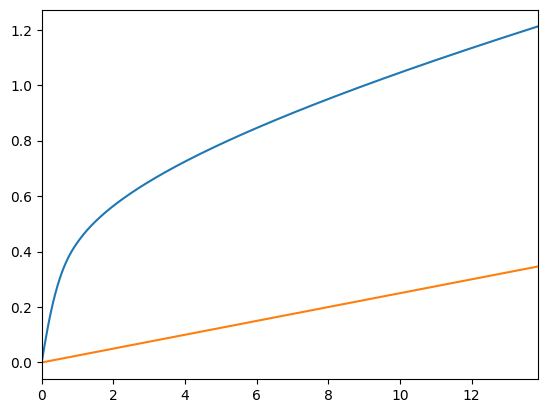

In [5]:
# Plot the consumption function and whatnot
m_upper = 1.5 * ExampleType.mTarg
conFunc_PF = lambda m: ExampleType.h * ExampleType.PFMPC + ExampleType.PFMPC * m
# plot_funcs([ExampleType.solution[0].cFunc,ExampleType.mSSfunc,ExampleType.cSSfunc],0,m_upper)
plot_funcs([ExampleType.solution[0].cFunc, ExampleType.solution[0].cFunc_U], 0, m_upper)

In [6]:
if do_simulation:
    ExampleType.assign_parameters(
        **simulation_values,
    )  # Set attributes needed for simulation
    ExampleType.track_vars = ["mLvl"]
    ExampleType.make_shock_history()
    ExampleType.initialize_sim()
    ExampleType.simulate()

In [7]:
# Now solve the same model using backward induction rather than the analytic method of TBS.
# The TBS model is equivalent to a Markov model with two states, one of them absorbing (permanent unemployment).
init_consumer_objects = {
    "CRRA": base_primitives["CRRA"],
    "Rfree": np.array(
        2 * [base_primitives["Rfree"]],
    ),  # Interest factor (same in both states)
    "PermGroFac": [
        np.array(
            2 * [base_primitives["PermGroFac"] / (1.0 - base_primitives["UnempPrb"])],
        ),
    ],  # Unemployment-compensated permanent growth factor
    "BoroCnstArt": None,  # Artificial borrowing constraint
    "PermShkStd": np.array([[0.0, 0.0]]),  # Permanent shock standard deviation
    "PermShkCount": 1,  # Number of shocks in discrete permanent shock distribution
    "TranShkStd": np.array([[0.0, 0.0]]),  # Transitory shock standard deviation
    "TranShkCount": 1,  # Number of shocks in discrete permanent shock distribution
    "T_cycle": 1,  # Number of periods in cycle
    "UnempPrb": np.array(
        [[0.0, 0.0]]
    ),  # Unemployment probability (not used, as the unemployment here is *permanent*, not transitory)
    "UnempPrbRet": None,  # Unemployment probability when retired (irrelevant here)
    "T_retire": 0,  # Age at retirement (turned off)
    "IncUnemp": np.array([[0.0, 0.0]]),  # Income when unemployed (irrelevant)
    "IncUnempRet": None,  # Income when unemployed and retired (irrelevant)
    "aXtraMin": 0.001,  # Minimum value of assets above minimum in grid
    "aXtraMax": ExampleType.mUpperBnd,  # Maximum value of assets above minimum in grid
    "aXtraCount": 48,  # Number of points in assets grid
    "aXtraExtra": None,  # Additional points to include in assets grid
    "aXtraNestFac": 3,  # Degree of exponential nesting when constructing assets grid
    "LivPrb": [np.array([1.0, 1.0])],  # Survival probability
    "DiscFac": base_primitives["DiscFac"],  # Intertemporal discount factor
    "AgentCount": 1,  # Number of agents in a simulation (irrelevant)
    "tax_rate": 0.0,  # Tax rate on labor income (irrelevant)
    "vFuncBool": False,  # Whether to calculate the value function
    "CubicBool": True,  # Whether to use cubic splines (False --> linear splines)
    "Mrkv_p11": [
        1.0 - base_primitives["UnempPrb"]
    ],  # Define the two state, absorbing unemployment Markov array
    "Mrkv_p22": [1.0],  # Define the two state, absorbing unemployment Markov array
}
MarkovType = MarkovConsumerType(**init_consumer_objects)  # Make a basic consumer type

In [8]:
employed_income_dist = DiscreteDistributionLabeled(
    pmv=np.ones(1),
    atoms=np.array([[1.0], [1.0]]),
    var_names=["PermShk", "TranShk"],
)  # Income distribution when employed
unemployed_income_dist = DiscreteDistributionLabeled(
    pmv=np.ones(1),
    atoms=np.array([[1.0], [0.0]]),
    var_names=["PermShk", "TranShk"],
)  # Income distribution when permanently unemployed

In [9]:
MarkovType.IncShkDstn = [
    [employed_income_dist, unemployed_income_dist],
]  # set the income distribution in each state
MarkovType.cycles = 0

In [10]:
# Solve the "Markov TBS" model
t_start = process_time()
MarkovType.solve()
t_end = process_time()
MarkovType.unpack("cFunc")

Solving the same model "the long way" took 1.3564517919999997 seconds.


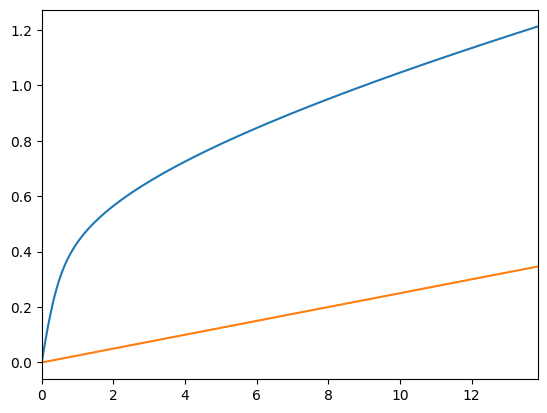

Difference between the (employed) consumption functions:


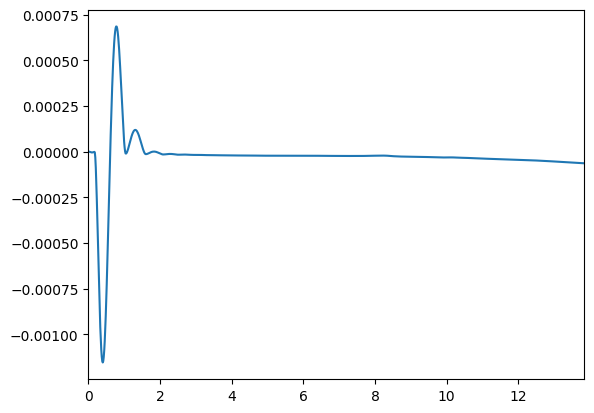

In [11]:
print(
    'Solving the same model "the long way" took ' + str(t_end - t_start) + " seconds.",
)
# plot_funcs([ExampleType.solution[0].cFunc,ExampleType.solution[0].cFunc_U],0,m_upper)
plot_funcs(MarkovType.cFunc[0], 0, m_upper)
diffFunc = lambda m: ExampleType.solution[0].cFunc(m) - MarkovType.cFunc[0][0](m)
print("Difference between the (employed) consumption functions:")
plot_funcs(diffFunc, 0, m_upper)